# Defend against attribute attacks in face recognition models

## Create an attack and defence using attribute modification - hair color and style, pose, make-up and else.




#### create conde env

In [ ]:
%pip install facenet-pytorch

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.12.0-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.12.0-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.12.0-Linux-x86_64.sh -b -f -p /usr/local/

#### install prerequisites

In [ ]:
!yes | conda create -n stargan-v2 python=3.6.7
!yes | conda activate stargan-v2
!yes | conda install -y pytorch=1.4.0 torchvision=0.5.0 cudatoolkit=10.0 -c pytorch
!yes | conda install x264=='1!152.20180717' ffmpeg=4.0.2 -c conda-forge
!yes | pip install opencv-python==4.1.2.30 ffmpeg-python==0.2.0 scikit-image==0.16.2
!yes | pip install pillow==7.0.0 scipy==1.2.1 tqdm==4.43.0 munch==2.5.0

In [ ]:
'''General packages'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
import cv2
from PIL import Image
import os
import time
from tqdm import *

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import glob
from datetime import datetime
import argparse
torch.manual_seed(42)
from facenet_pytorch import MTCNN, InceptionResnetV1


plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

In [ ]:
! git clone https://github.com/shellyfra/Defend_against_attribute_attacks_in_face_recognition_models.git

Cloning into 'Defend_against_attribute_attacks_in_face_recognition_models'...
remote: Enumerating objects: 353, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 353 (delta 20), reused 51 (delta 15), pack-reused 294
Receiving objects: 100% (353/353), 26.75 MiB | 12.72 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [ ]:
%cd Defend_against_attribute_attacks_in_face_recognition_models

/content/Defend_against_attribute_attacks_in_face_recognition_models


In [ ]:
from utils import train, set_parameter_requires_grad, eval_acc, imshow_no_normalization, get_params_to_update, imshow

In [ ]:
%cd StarGAN_with_our_changes

/content/Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes


In [ ]:
# Download the STARGAN pretrained model on celebA-HQ
!bash download.sh stargan-pre-trained
# Download an attention pretrained model for the usage of the generation
!bash download.sh wing

In [ ]:
# install our pre-trained models on celebA-HQ dataset (with / without augmentation and with attributes)
!bash download.sh models-weights

--2023-01-23 05:56:35--  https://docs.google.com/uc?export=download&confirm=t&id=1G5QNRswQjVNJ3gDTf0W8-vsiuFuVqDY_
Resolving docs.google.com (docs.google.com)... 142.251.31.101, 142.251.31.113, 142.251.31.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.31.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kkshrnvl9n3qjk6gcm174rp2frqt1kso/1674453375000/05560778185249539437/*/1G5QNRswQjVNJ3gDTf0W8-vsiuFuVqDY_?e=download&uuid=1b97eebe-8f72-4169-9a97-b54d28473d41 [following]
--2023-01-23 05:56:36--  https://doc-14-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kkshrnvl9n3qjk6gcm174rp2frqt1kso/1674453375000/05560778185249539437/*/1G5QNRswQjVNJ3gDTf0W8-vsiuFuVqDY_?e=download&uuid=1b97eebe-8f72-4169-9a97-b54d28473d41
Resolving doc-14-08-docs.googleusercontent.com (doc-14-08-docs.googleusercontent.com)... 142.251.31.132, 

In [ ]:
!bash download.sh celeba-hq-dataset

## Attack a specific identity on facenet model 

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('model_path', type=str, default=r'/content/Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes/', help='the path to save model weights after training')
parser.add_argument('image_size', type=int, default=256, help='the image size to enter the face recognition model') # 256 is the size for FaceNet
parser.add_argument('lr', type=float, default=0.001, help='the learning rate used for train on CelebA data')
parser.add_argument('momentum', type=float, default=0.9, help='the momentum used for train on CelebA data')
parser.add_argument('train_celebA_num_epochs', type=int, default=20, help='the number of epochs used for the first train phase on CelebA data with no augmentation')
parser.add_argument('batch_size', type=int, default=16, help='train and test batch size')
parser.add_argument('num_workers', type=int, default=2, help='train and test num workers')
parser.add_argument('num_epochs', type=int, default=20, help='the number of epochs used for the first train phase on CelebA data with no augmentation')


args = parser.parse_args(args=['/content/Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes/', '256', '1e-3', '0.9', '20', '16', '2', '20'])
print(args)

Namespace(batch_size=16, image_size=256, lr=0.001, model_path='/content/Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes/', momentum=0.9, num_epochs=20, num_workers=2, train_celebA_num_epochs=20)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
!python main.py --mode sample --num_domains 2 --resume_iter 100000 --w_hpf 1 \
               --checkpoint_dir expr/checkpoints/celeba_hq \
               --result_dir attack_objects\
               --src_dir attack_objects \
               --ref_dir attack_reference \
               --skip_rate 1


Start_sampling sample: 0
/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
transforms_orig = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    ])

transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
data_dir = './CelebA_HQ_facial_identity_dataset'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.batch_size)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 4263
Test dataset size: 1215
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '22

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
num_classes = len(class_names) # clebA HQ sub dataset

celebA_facenet = InceptionResnetV1(pretrained='vggface2').to(device)
celebA_facenet = set_parameter_requires_grad(celebA_facenet, num_classes)

model_name = 'CelebA_HQ_Facenet_without_aug.pth'
state = torch.load(f'{args.model_path}/models/{model_name}', map_location=device)

celebA_facenet.load_state_dict(state['net'])
celebA_facenet = celebA_facenet.to(device).eval()
celebA_facenet.classify = True

source_images = {108:'1919.jpg', 188: '12236.jpg', 563:'5103.jpg', 701: '11670.jpg', 80:'13726.jpg'}
reference_images = {129: '10178.jpg', }
id_to_attack = [f'attack_objects/{id}/{img_name}' for id, img_name in source_images.items()] 
reference_img_paths = [f'attack_reference/{id}/{img_name}' for id, img_name in reference_images.items()] 
id_after_attack = [f'attack_objects/{i}/new_image_{i}_{0}_{m}.jpg' for m, i in enumerate(source_images.keys()) for k, j in enumerate(reference_images.keys())]


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
def test_attack(state, celebA_facenet=celebA_facenet):
    num_classes = len(class_names) # clebA HQ sub dataset
    # print(num_classes)
    from facenet_pytorch import MTCNN, InceptionResnetV1
    facenet = InceptionResnetV1(pretrained='vggface2').to(device)
    facenet = set_parameter_requires_grad(celebA_facenet, num_classes)

    facenet.load_state_dict(state['net'])
    facenet = facenet.to(device)
    facenet.classify = True
    facenet.eval()
    id_to_attack_imgs = [transforms_orig(Image.open(img_path).convert('RGB')) for img_path in id_to_attack]
    reference_imgs = [transforms_orig(Image.open(img_path).convert('RGB')) for img_path in reference_img_paths]
    id_after_attack_imgs = [transforms_orig(Image.open(img_path).convert('RGB')) for img_path in id_after_attack]
    # print(len(id_after_attack_imgs))
    input = torch.stack(id_to_attack_imgs)

    facenet.eval()
    facenet.classify = True

    img_probs = celebA_facenet(input.to(device))
    out0 = torchvision.utils.make_grid(input)
    imshow_no_normalization(out0, title=f'predicted class = {[class_names[prob.argmax().item()] for prob in img_probs]}') # title=[x for x in img_probs.argmax(axis=1)]

    input = torch.stack(id_after_attack_imgs)
    img_probs = celebA_facenet(input.to(device))
    out0 = torchvision.utils.make_grid(input)
    imshow_no_normalization(out0, title=f'predicted class = {[class_names[prob.argmax().item()] for prob in img_probs]}') # title=[x for x in img_probs.argmax(axis=1)]

## Create augmentations for each image in the train dataset

In [ ]:
!python main.py --mode sample --resume_iter 100000 --w_hpf 1 \
               --checkpoint_dir expr/checkpoints/celeba_hq \
               --result_dir CelebA_HQ_facial_identity_dataset/train \
               --src_dir CelebA_HQ_facial_identity_dataset/train \
               --ref_dir defence_reference \
               --val_batch_size 4096 \
               --skip_rate 1


Start_sampling sample: 0
/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
!python main.py --mode sample --resume_iter 100000 --w_hpf 1 \
               --checkpoint_dir expr/checkpoints/celeba_hq \
               --result_dir CelebA_HQ_facial_identity_dataset/test \
               --src_dir CelebA_HQ_facial_identity_dataset/test \
               --ref_dir defence_reference \
               --val_batch_size 4096 \
               --skip_rate 1

Start_sampling sample: 0
/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
data_dir = './CelebA_HQ_facial_identity_dataset'
attr_aug_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
attr_aug_test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

attr_aug_train_dataloader = torch.utils.data.DataLoader(attr_aug_train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
attr_aug_test_dataloader = torch.utils.data.DataLoader(attr_aug_test_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)

print('Attr Train dataset size:', len(attr_aug_train_dataset))
print('Attr Test dataset size:', len(attr_aug_test_dataset))

Attr Train dataset size: 12455
Attr Test dataset size: 3645


In [ ]:
celebA_facenet_attr_aug = InceptionResnetV1(pretrained='vggface2').to(device)
celebA_facenet_attr_aug = set_parameter_requires_grad(celebA_facenet_attr_aug, num_classes)

model_name = 'CelebA_HQ_Facenet_without_aug.pth'
state = torch.load(f'{args.model_path}/models/{model_name}', map_location=device)
celebA_facenet_attr_aug.load_state_dict(state['net'])

params_to_update2 = get_params_to_update(celebA_facenet_attr_aug)
optimizer2 = torch.optim.SGD(params_to_update2, lr=args.lr, momentum=args.momentum)
criterion = nn.CrossEntropyLoss()

	 logits.weight
	 logits.bias


In [ ]:
attr_aug_train_losses, attr_aug_test_losses, attr_aug_train_acc, attr_aug_test_acc = train(celebA_facenet_attr_aug, criterion, optimizer2, 
                                                                       args.num_epochs, attr_aug_train_dataloader, attr_aug_train_dataset, attr_aug_test_dataloader,
                                                                        attr_aug_test_dataset, args.model_path, with_aug=True, free_text='attr', device=device)



779it [01:08, 11.38it/s]

[Train #0] Loss: 2.1194 Acc: 54.6768% Time: 68.5852s


[Test #0] Loss: 1.7772 Acc: 62.2222% Time: 88.3162s
==> Saving model ...


779it [01:08, 11.38it/s]

[Train #1] Loss: 1.6834 Acc: 62.8422% Time: 157.0702s


[Test #1] Loss: 1.5605 Acc: 67.2154% Time: 176.6076s
==> Saving model ...


779it [01:07, 11.52it/s]

[Train #2] Loss: 1.4740 Acc: 67.5873% Time: 244.5349s


[Test #2] Loss: 1.4236 Acc: 70.7545% Time: 263.9569s
==> Saving model ...


779it [01:07, 11.46it/s]

[Train #3] Loss: 1.3438 Acc: 70.3412% Time: 332.2313s


[Test #3] Loss: 1.3427 Acc: 72.6475% Time: 351.7287s
==> Saving model ...


779it [01:08, 11.42it/s]

[Train #4] Loss: 1.2341 Acc: 73.3119% Time: 420.2538s


[Test #4] Loss: 1.2596 Acc: 74.1838% Time: 439.3374s
==> Saving model ...


779it [01:07, 11.51it/s]

[Train #5] Loss: 1.1711 Acc: 74.4119% Time: 507.3221s


[Test #5] Loss: 1.2421 Acc: 74.8148% Time: 526.9792s
==> Saving model ...


779it [01:07, 11.49it/s]

[Train #6] Loss: 1.1016 Acc: 76.4352% Time: 595.0976s


[Test #6] Loss: 1.2007 Acc: 75.2538% Time: 614.1423s
==> Saving model ...


779it [01:07, 11.57it/s]

[Train #7] Loss: 1.0601 Acc: 77.3183% Time: 681.7555s


[Test #7] Loss: 1.1886 Acc: 75.2538% Time: 701.1482s
==> Saving model ...


779it [01:07, 11.53it/s]

[Train #8] Loss: 1.0356 Acc: 77.2541% Time: 768.9900s


[Test #8] Loss: 1.1619 Acc: 75.8848% Time: 788.0709s
==> Saving model ...


779it [01:08, 11.44it/s]

[Train #9] Loss: 0.9960 Acc: 78.4986% Time: 856.4440s


[Test #9] Loss: 1.1386 Acc: 75.9671% Time: 876.2051s
==> Saving model ...


779it [01:07, 11.49it/s]

[Train #10] Loss: 0.9613 Acc: 79.0686% Time: 944.3201s


[Test #10] Loss: 1.1326 Acc: 76.2414% Time: 964.0241s
==> Saving model ...


779it [01:08, 11.43it/s]

[Train #11] Loss: 0.9436 Acc: 79.5504% Time: 1032.4553s


[Test #11] Loss: 1.1257 Acc: 76.4335% Time: 1051.7941s
==> Saving model ...


779it [01:07, 11.50it/s]

[Train #12] Loss: 0.9293 Acc: 79.5745% Time: 1119.8076s


[Test #12] Loss: 1.1002 Acc: 76.8724% Time: 1140.2089s
==> Saving model ...


779it [01:08, 11.38it/s]

[Train #13] Loss: 0.9142 Acc: 79.2051% Time: 1208.9772s


[Test #13] Loss: 1.1061 Acc: 76.6529% Time: 1228.5898s
==> Saving model ...


779it [01:08, 11.38it/s]

[Train #14] Loss: 0.8935 Acc: 80.1365% Time: 1297.3737s


[Test #14] Loss: 1.0994 Acc: 76.5981% Time: 1317.2770s
==> Saving model ...


779it [01:08, 11.43it/s]

[Train #15] Loss: 0.8785 Acc: 80.1847% Time: 1385.7564s


[Test #15] Loss: 1.0977 Acc: 76.6529% Time: 1405.0531s
==> Saving model ...


779it [01:08, 11.39it/s]

[Train #16] Loss: 0.8609 Acc: 80.8591% Time: 1473.7429s


[Test #16] Loss: 1.0805 Acc: 76.7901% Time: 1493.3615s
==> Saving model ...


779it [01:07, 11.59it/s]

[Train #17] Loss: 0.8476 Acc: 81.1160% Time: 1560.8483s


[Test #17] Loss: 1.0773 Acc: 77.2565% Time: 1580.3204s
==> Saving model ...


779it [01:08, 11.45it/s]

[Train #18] Loss: 0.8492 Acc: 80.9394% Time: 1648.6386s


[Test #18] Loss: 1.0604 Acc: 77.3663% Time: 1667.6491s
==> Saving model ...


779it [01:07, 11.61it/s]


[Train #19] Loss: 0.8396 Acc: 80.9554% Time: 1735.0712s
[Test #19] Loss: 1.0677 Acc: 77.3937% Time: 1754.2826s
==> Saving model ...
==> Finished Training ...


In [ ]:
attr_aug_test_acc = np.array([t.cpu().item() for t in attr_aug_test_acc])
attr_aug_train_acc = np.array([t.cpu().item() for t in attr_aug_train_acc])
attr_aug_test_losses = np.array(attr_aug_test_losses)
attr_aug_train_losses = np.array(attr_aug_train_losses)

np.save(args.model_path + r'/models/attr_aug_test_acc.npy', attr_aug_test_acc)
np.save(args.model_path + r'/models/attr_aug_train_acc.npy', attr_aug_train_acc)
np.save(args.model_path + r'/models/attr_aug_test_losses.npy', attr_aug_test_losses)
np.save(args.model_path + r'/models/attr_aug_train_losses.npy', attr_aug_train_losses)

In [ ]:
# if nessecary
attr_aug_test_acc = np.load(args.model_path + r'/models/attr_aug_test_acc.npy')
attr_aug_train_acc = np.load(args.model_path + r'/models/attr_aug_train_acc.npy')
attr_aug_test_losses = np.load(args.model_path + r'/models/attr_aug_test_losses.npy')
attr_aug_train_losses = np.load(args.model_path + r'/models/attr_aug_train_losses.npy')

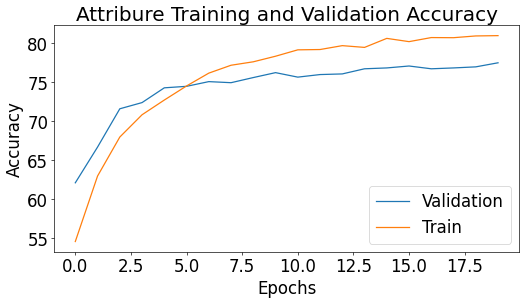

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Attribure Training and Validation Accuracy")
plt.plot(attr_aug_test_acc,label="Validation")
plt.plot(attr_aug_train_acc,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

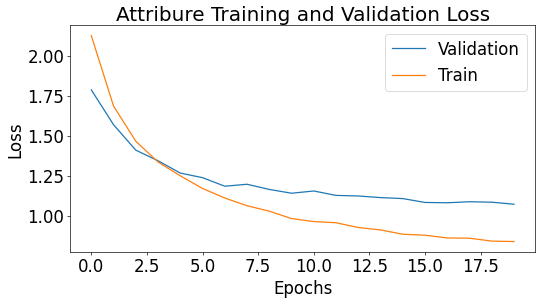

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Attribure Training and Validation Loss")
plt.plot(attr_aug_test_losses,label="Validation")
plt.plot(attr_aug_train_losses,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ***The identities BEFORE the defence***

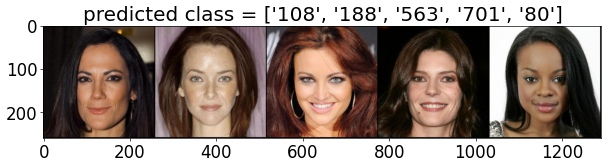

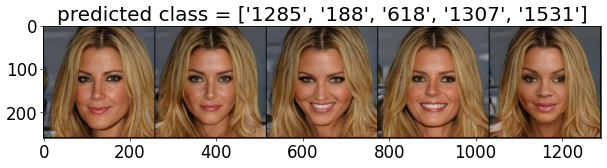

In [ ]:
model_name = 'CelebA_HQ_Facenet_without_aug.pth'
path_name = f'{args.model_path}/models/{model_name}'
old_state = torch.load(path_name, map_location=device)
test_attack(old_state)

# ***The identities AFTER the defence***

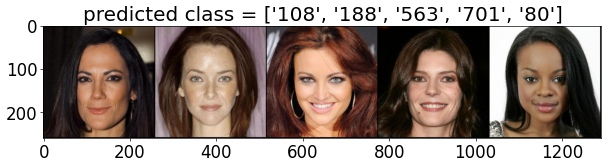

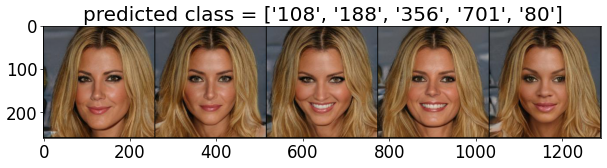

In [ ]:
model_name = 'CelebA_HQ_Facenet_with_aug_attribute.pth'
path_name = f'{args.model_path}/models/{model_name}'
new_state = torch.load(path_name, map_location=device)
test_attack(new_state)

In [ ]:
def model_pre_proccess(state):
    from facenet_pytorch import MTCNN, InceptionResnetV1
    facenet = InceptionResnetV1(pretrained='vggface2').to(device)
    facenet = set_parameter_requires_grad(celebA_facenet, num_classes)

    facenet.load_state_dict(state['net'])
    facenet = facenet.to(device)
    facenet.classify = True
    facenet.eval()
    return facenet

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
model_without_aug = InceptionResnetV1(pretrained='vggface2').to(device)
model_without_aug = set_parameter_requires_grad(model_without_aug, num_classes)

model_name = 'CelebA_HQ_Facenet_without_aug.pth'
state = torch.load(f'{args.model_path}/models/{model_name}', map_location=device)
model_without_aug.load_state_dict(state['net'])
model_without_aug = model_without_aug.to(device)

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
model_with_aug = InceptionResnetV1(pretrained='vggface2').to(device)
model_with_aug = set_parameter_requires_grad(model_with_aug, num_classes)

model_name = 'CelebA_HQ_Facenet_with_aug_fine_tune.pth'
state = torch.load(f'{args.model_path}/models/{model_name}', map_location=device)
model_with_aug.load_state_dict(state['net'])
model_with_aug = model_with_aug.to(device)

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
model_with_attr = InceptionResnetV1(pretrained='vggface2').to(device)
model_with_attr = set_parameter_requires_grad(model_with_attr, num_classes)

model_name = 'CelebA_HQ_Facenet_with_aug_attribute.pth'
state = torch.load(f'{args.model_path}/models/{model_name}', map_location=device)
model_with_attr.load_state_dict(state['net'])
model_with_attr = model_with_attr.to(device)

In [ ]:
print("evaluate on fine-tuned not augmented data:")
eval_acc(model_without_aug, attr_aug_test_dataloader, device)

print("evaluate on fine-tuned augmented data:")
eval_acc(model_with_aug, attr_aug_test_dataloader, device)

print("evaluate on attribute change data:")
eval_acc(model_with_attr, attr_aug_test_dataloader, device)

evaluate on fine-tuned not augmented data:
Loss: 2.8851 Acc: 44.0329% 
evaluate on fine-tuned augmented data:
Loss: 3.0072 Acc: 41.7833% 
evaluate on attribute change data:
Loss: 1.0710 Acc: 77.5034% 


(1.0709630690157332, tensor(77.5034, device='cuda:0'))